In [1]:
# import os
# os.environ["KERAS_BACKEND"] = "theano"
# import keras; import keras.backend
# if keras.backend.backend() != 'theano':
#     raise BaseException("This script uses other backend")
# else:
#     keras.backend.set_image_dim_ordering('th')
#     print("Backend ok")

Using Theano backend.


Backend ok


In [1]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
import nltk
nltk.download('punkt')

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
#!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
#!apt-get update -qq 2>&1 > /dev/null
#!apt-get -y install -qq google-drive-ocamlfuse fuse
!wget https://launchpad.net/~alessandro-strada/+archive/ubuntu/google-drive-ocamlfuse-beta/+build/15331130/+files/google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!dpkg -i google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!apt-get install -f
!apt-get -y install -qq fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
--2018-10-15 15:12:01--  https://launchpad.net/~alessandro-strada/+archive/ubuntu/google-drive-ocamlfuse-beta/+build/15331130/+files/google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
Resolving launchpad.net (launchpad.net)... 91.189.89.223, 91.189.89.222
Connecting to launchpad.net (launchpad.net)|91.189.89.223|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://launchpadlibrarian.net/386846978/google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb [following]
--2018-10-15 15:12:02--  https://launchpadlibrarian.net/386846978/google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
Resolving launchpadlibrarian.net (launchpadlibrarian.net)... 91.189.89.228, 91.189.89.229
Connecting to launchpadlibrarian.net (launchpadlibrarian.net)|91.189.89.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1232624 (1.2M) [application/x-debian-package]
Saving to: ‘google-drive-ocamlfuse_

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [4]:
!ls drive/ml_apps

ben.odt		     embeddings_index.pickle  LSTM1500.h5     texts.txt
ben.txt		     fra.txt		      LSTM2000.h5
conversation_2.json  LSTM0500.h5	      s2s_bengali.h5
conversation.json    LSTM1000.h5	      s2s.h5


In [0]:
import pickle
glove_embeddings = pickle.load( open( "drive/ml_apps/embeddings_index.pickle", "rb" ) )

In [6]:
len(glove_embeddings['horse'])

100

In [7]:
len(glove_embeddings)

400000

In [0]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 100  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
max_words = 10000  # Number of words in the train set to be used
# Path to the data txt file on disk.
data_path = 'drive/ml_apps/ben.txt'

In [0]:
# Vectorize the data.
input_texts = []
target_texts = []

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "<start>" as the "start sequence" word
    # for the targets, and "<EOS>" as "end sequence" word.
    target_text = ' START_ ' + target_text + ' _EOS '
    input_texts.append(input_text)
    target_texts.append(target_text)
    


In [0]:
tok_in=[]
tok_target=[]

for i in range(len(input_texts)):
  tok_in.append(nltk.word_tokenize(input_texts[i].lower()))
for i in range(len(target_texts)):
  tok_target.append(nltk.word_tokenize(target_texts[i].lower()))

In [11]:
tok_in[202]

['leave', 'us', '.']

In [12]:
tok_target[201]

['start_', 'আমাকে', 'চেড়ে', 'দে।', '_eos']

In [0]:
input_words = set()
target_words = set()
for i in range(len(tok_in)):
  for word in tok_in[i]:
#     print(word)
    if word not in input_words:
      input_words.add(word)
for i in range(len(tok_target)):
  for word in tok_target[i]:
#     print(word)
    if word not in target_words:
      target_words.add(word)

In [14]:
if "go" in input_words:
  print('found')

found


In [0]:
input_words = sorted(list(input_words))
target_words = sorted(list(target_words))
num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)
max_encoder_seq_length = max([len(tok_in[i]) for i in range(len(tok_in))])
max_decoder_seq_length = max([len(tok_target[i]) for i in range(len(tok_target))])

In [16]:
print('Number of samples:', len(input_texts))
print('Number of unique input/encoder tokens:', num_encoder_tokens)
print('Number of unique output/decoder tokens:', num_decoder_tokens)
print('Max sequence length for inputs/encoder:', max_encoder_seq_length)
print('Max sequence length for outputs/decoder:', max_decoder_seq_length)

Number of samples: 4379
Number of unique input/encoder tokens: 1847
Number of unique output/decoder tokens: 3345
Max sequence length for inputs/encoder: 22
Max sequence length for outputs/decoder: 22


In [0]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_words)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_words)])

In [18]:
input_token_index[input_words[5]]

5

In [0]:
#Generate embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_words,embedding_dim))

for word, i in input_token_index.items():
  embedding_vector = glove_embeddings.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector


In [20]:
embedding_matrix.shape

(10000, 100)

In [0]:
encoder_input_data = np.zeros(
    (len(tok_in), max_encoder_seq_length),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(tok_target), max_decoder_seq_length),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(tok_target),  max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [23]:
encoder_input_data[201]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)

In [24]:
np.fliplr(encoder_input_data)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [25]:
decoder_target_data.shape

(4379, 22, 3345)

In [0]:
#Index encoding of encoder_inpu, decoder_input and decoder_target
for i in range(len(tok_in)):
  for j in range(len(tok_in[i])):
#     print(j)
    encoder_input_data[i,j] = input_token_index[tok_in[i][j]]
    
for i in range(len(tok_target)):
  for t, word in enumerate(tok_target[i]):
    decoder_input_data[i,t] = target_token_index[word]
    if t > 0:
      # decoder_target_data will be ahead by one timestep
      # and will not include the start character.
      decoder_target_data[i, t - 1, target_token_index[word]] = 1.

In [27]:
encoder_input_data[201]

array([905., 991.,  12.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
      dtype=float32)

In [0]:
encoder_input_data = np.fliplr(encoder_input_data)

In [29]:
encoder_input_data[201]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  12., 991., 905.],
      dtype=float32)

In [31]:
encoder_input_data.shape

(4379, 22)

In [32]:
decoder_input_data.shape

(4379, 22)

In [33]:
decoder_target_data.shape

(4379, 22, 3345)

In [0]:
from keras.layers import Embedding

In [0]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_word_index = dict(
    (i, word) for word, i in input_token_index.items())
reverse_target_word_index = dict(
    (i, word) for word, i in target_token_index.items())

In [36]:
reverse_target_word_index[442]

'এসেছে।'

In [37]:
reverse_input_word_index[np.argmax(decoder_target_data[9,3,:])]

'!'

In [0]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(max_words, latent_dim, weights=[embedding_matrix], trainable=False, mask_zero=True)
#encoder_embedding = Embedding(num_encoder_tokens, latent_dim, weights=[embedding_matrix], trainable=False, mask_zero=True)
embedding_output = encoder_embedding(encoder_inputs)
#encoder1 = LSTM(latent_dim, return_state=True, return_sequences=True)
#encoder_outputs_1,state_h_1,state_c_1 = encoder1(embedding_output)
encoder = LSTM(latent_dim, return_state=True) #orig
encoder_outputs, state_h, state_c = encoder(embedding_output) #orig
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]
#encoder_states_1 = [state_h_1, state_c_1]

In [0]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

decoder_embedding = Embedding(num_decoder_tokens, latent_dim)
dec_embed_out = decoder_embedding(decoder_inputs)
# # We set up our decoder to return full output sequences,
# # and to return internal states as well. We don't use the
# # return states in the training model, but we will use them in inference.
#decoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)

#decoder_outputs_1, _, _ = decoder_lstm1(decoder_inputs,
#                                    initial_state=encoder_states_1)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(dec_embed_out, initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_dense_outputs = decoder_dense(decoder_outputs)

#x = Embedding(num_decoder_tokens, latent_dim)(decoder_inputs)
#x = LSTM(latent_dim, return_sequences=True)(x, initial_state=encoder_states)
#decoder_outputs = Dense(num_decoder_tokens, activation='softmax')(x)



In [0]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_dense_outputs)

In [42]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    1000000     input_2[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 100)    334500      input_3[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

In [43]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)
# print(oh_target_data.shape)

(4379, 22)
(4379, 22)
(4379, 22, 3345)


In [44]:
model.layers[6].input_shape



(None, None, 100)

In [0]:
# model.layers[1].set_weights([embedding_matrix])
# model.layers[1].trainable = False

In [46]:
#from keras import losses
# Run training
# Note that `decoder_target_data` needs to be one-hot encoded,
# rather than sequences of integers like `decoder_input_data`!
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=100,
          validation_split=0.2)
                   

Train on 3503 samples, validate on 876 samples
Epoch 1/100
3503/3503 [==============================] - 9s 3ms/step - loss: 1.5192 - acc: 0.0430 - val_loss: 2.4969 - val_acc: 0.0455
Epoch 2/100
3503/3503 [==============================] - 8s 2ms/step - loss: 1.2387 - acc: 0.0455 - val_loss: 2.4808 - val_acc: 0.0540
Epoch 3/100
3503/3503 [==============================] - 8s 2ms/step - loss: 1.2090 - acc: 0.0546 - val_loss: 2.4949 - val_acc: 0.0548
Epoch 4/100
3503/3503 [==============================] - 8s 2ms/step - loss: 1.1871 - acc: 0.0548 - val_loss: 2.4962 - val_acc: 0.0550
Epoch 5/100
3503/3503 [==============================] - 8s 2ms/step - loss: 1.1631 - acc: 0.0548 - val_loss: 2.4646 - val_acc: 0.0549
Epoch 6/100
3503/3503 [==============================] - 8s 2ms/step - loss: 1.1302 - acc: 0.0561 - val_loss: 2.4171 - val_acc: 0.0580
Epoch 7/100
3503/3503 [==============================] - 8s 2ms/step - loss: 1.0856 - acc: 0.0627 - val_loss: 2.3437 - val_acc: 0.0685
Epoch 8/

In [47]:
history_dict = history.history
history_dict.keys()


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [0]:
import matplotlib.pyplot as plt
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1,101)

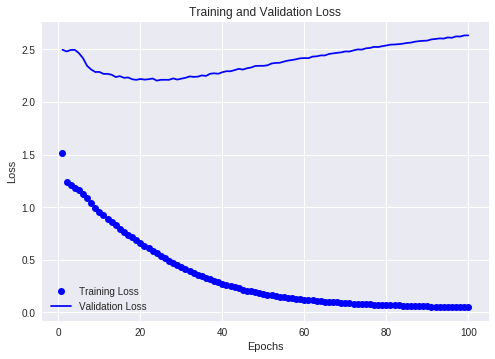

In [49]:
plt.plot(epochs,loss_values,'bo', label="Training Loss")
plt.plot(epochs,val_loss_values,'b',label="Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

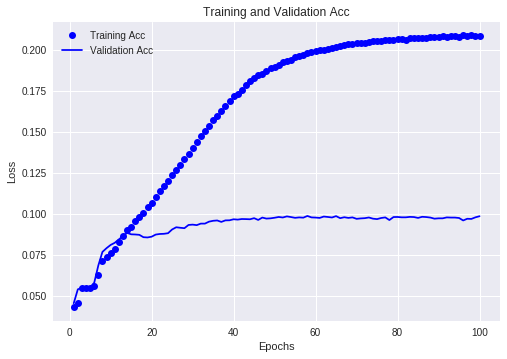

In [50]:
plt.plot(epochs,acc_values,'bo', label="Training Acc")
plt.plot(epochs,val_acc_values,'b',label="Validation Acc")
plt.title('Training and Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [57]:
# Save model
model.save('drive/ml_apps/s2s_bengali.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/topology.py:2379: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 100) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [59]:
model.layers[4].input_shape

(None, None, 100)

In [60]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
dex_out = decoder_embedding(decoder_inputs)

decoder_outputs, dstate_h, dstate_c = decoder_lstm(dex_out, initial_state=decoder_states_inputs)
decoder_states = [dstate_h, dstate_c]
decoder_dense_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_dense_outputs] + decoder_states)
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 100)    334500      input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
lstm_2 (LS

In [61]:
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                [(None, 100), (None, 100) 80400     
Total params: 1,080,400
Trainable params: 80,400
Non-trainable params: 1,000,000
_________________________________________________________________


In [0]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_word_index = dict(
    (i, word) for word, i in input_token_index.items())
reverse_target_word_index = dict(
    (i, word) for word, i in target_token_index.items())

In [0]:
import os

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    
    states_value = encoder_model.predict(input_seq)
    

    # Generate empty target sequence of length 1.
    
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    
    target_seq[0, 0] = target_token_index['start_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    token_index = []
    #t = 1
    while not stop_condition:
    #for t in range(0,max_decoder_seq_length):
        
        output_tokens,h,c = decoder_model.predict(
             [target_seq] + states_value)
        
        # Sample a token
        
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_word_index[sampled_token_index]

        if (sampled_word != '_eos'):
          decoded_sentence += sampled_word + ' '
          token_index.append(sampled_token_index)

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '_eos' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index


        # Update states
        states_value = [h, c]
        
    return decoded_sentence

In [74]:
for seq_index in range(230,250):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index+1]
    
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: They won.
Decoded sentence: ওরা জিতলো। 
-
Input sentence: They won.
Decoded sentence: ওরা জিতলো। 
-
Input sentence: Tom came.
Decoded sentence: টম এসেছিলো। 
-
Input sentence: Tom came.
Decoded sentence: টম এসেছিলো। 
-
Input sentence: Tom died.
Decoded sentence: টম মারা গেছে। 
-
Input sentence: Tom died.
Decoded sentence: টম মারা গেছে। 
-
Input sentence: Tom knew.
Decoded sentence: টম জানতো। 
-
Input sentence: Tom lied.
Decoded sentence: টম মিথ্যা কথা বললো। 
-
Input sentence: Tom lies.
Decoded sentence: টম মিথ্যে বলে। 
-
Input sentence: Tom lost.
Decoded sentence: টম হেরে গেলো। 
-
Input sentence: Trust me.
Decoded sentence: আমাকে বিশ্বাস করুন। 
-
Input sentence: Trust me.
Decoded sentence: আমাকে বিশ্বাস করুন। 
-
Input sentence: Trust me.
Decoded sentence: আমাকে বিশ্বাস করুন। 
-
Input sentence: Try hard.
Decoded sentence: আরও চেষ্টা করুন। 
-
Input sentence: Try hard.
Decoded sentence: আরও চেষ্টা করুন। 
-
Input sentence: Try hard.
Decoded sentence: আরও চেষ্টা করুন। 
-
In

In [0]:
def prepare_text(input_text):
  tokens_in=[]
  input_data = np.zeros(
    (1,max_encoder_seq_length),
    dtype='float32')
  tokens_in = nltk.word_tokenize(input_text.lower())
  for i in range(len(tokens_in)):
    print(tokens_in[i])
    if tokens_in[i] in input_words:
     
      input_data[0,i] = input_token_index[tokens_in[i]]
    else:
      input_data[0,i] = input_token_index['.']
  input_data = np.fliplr(input_data)
  return input_data

In [76]:
input_token_index['dinner']

455

In [91]:
data = prepare_text("What do you want?")
print(data[0,], data.shape)

what
do
you
want
?
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.   30. 1746. 1838.  467. 1775.] (1, 22)


In [92]:
new_sentence = decode_sequence(data)
print('-')
#print('Input sentence:', )
print('Decoded sentence:', new_sentence)

-
Decoded sentence: তুমি কী চাও ? 
